In [8]:

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import gc
from tensorflow import keras
from keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import os
# tf.keras.mixed_precision.set_global_policy("mixed_float16")
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from dataset import *
from modules import *
from pixel import *
from train import *
from predict import *

LOAD_WEIGHTS = False
CHECKPOINT = './model_weights/new_weights'
PIXEL_CHECKPOINT = './CNNmodel_weights/pixel_weights'
ROOT_DIR = r"C:\Users\jorda\Documents"



In [2]:
train_np, test_np, train_imgs, test_imgs, train_variance = load_oasis(ROOT_DIR)

Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.
<class 'numpy.ndarray'> (2416, 4, 256, 256, 1)
<class 'numpy.ndarray'> (544, 256, 256, 1)


In [3]:
latent_dim = 64
num_embeddings = 8

vqvae_trainer = VQVAETrainer(train_variance, latent_dim, num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

history = train_vqvae(vqvae_trainer, train_imgs, num_epochs=15, 
                        CHECKPOINT='./model_weights/new_weights', LOAD_WEIGHTS=LOAD_WEIGHTS)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        4160      
                                                                 
Total params: 22,976
Trainable params: 22,976
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6

In [4]:
if not LOAD_WEIGHTS:
    plot_training(history)

1/1 [==============================] - 3s 3s/step


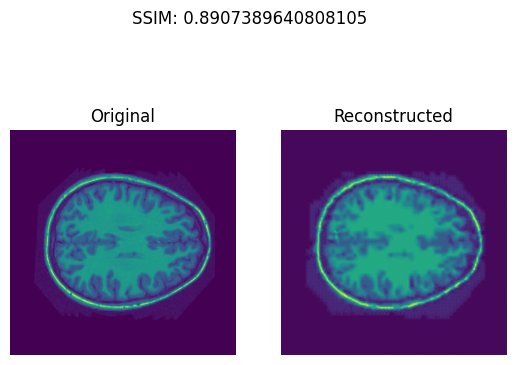

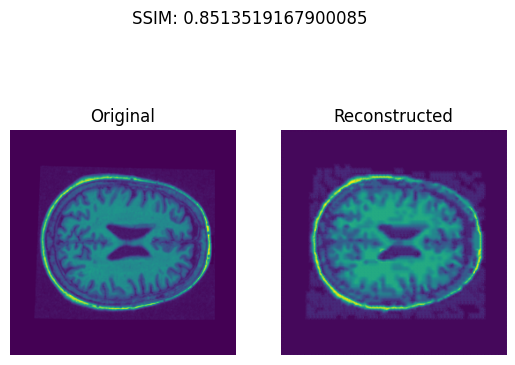

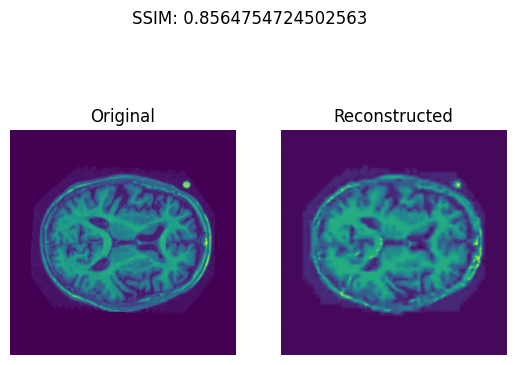

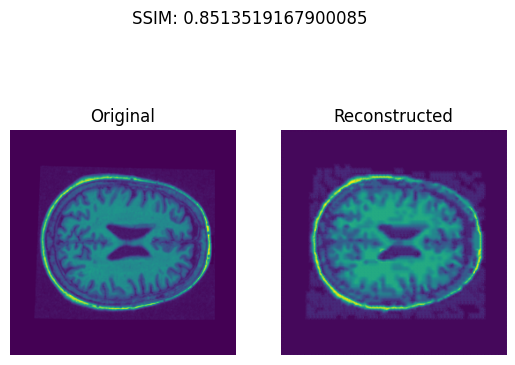

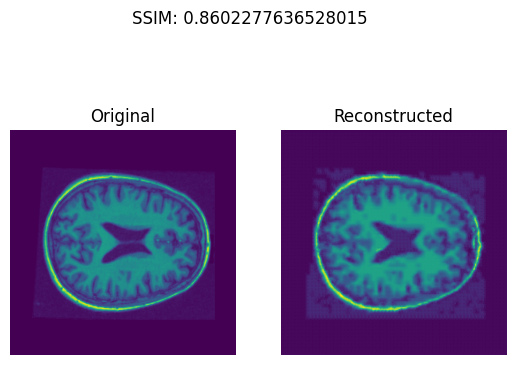

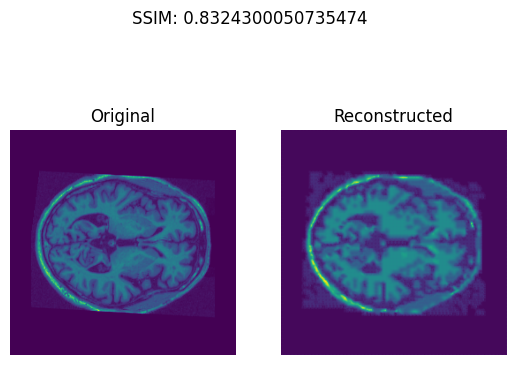

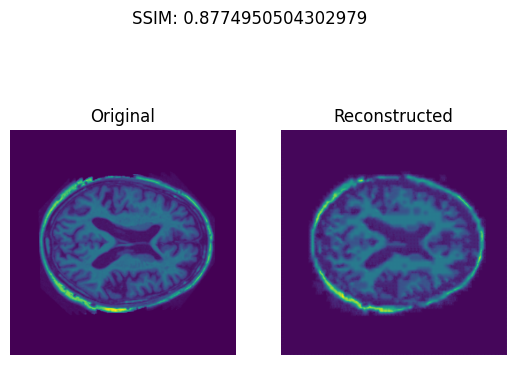

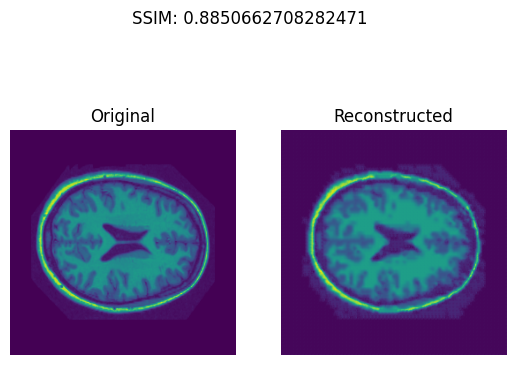

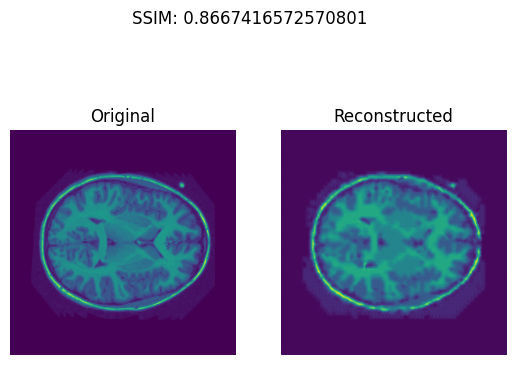

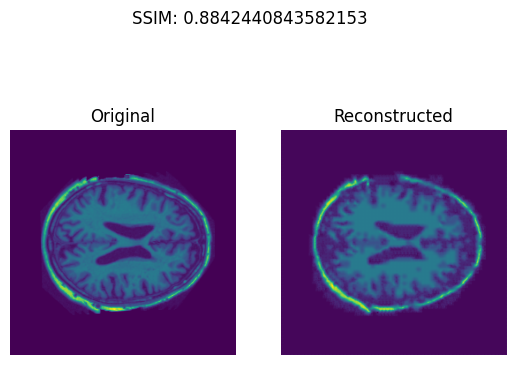

1/1 [==============================] - 0s 39ms/step


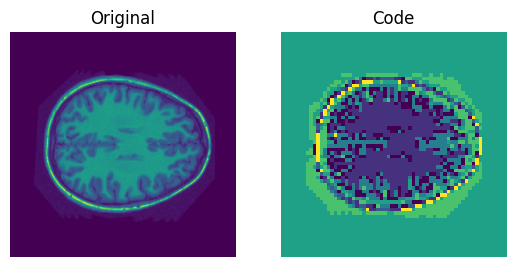

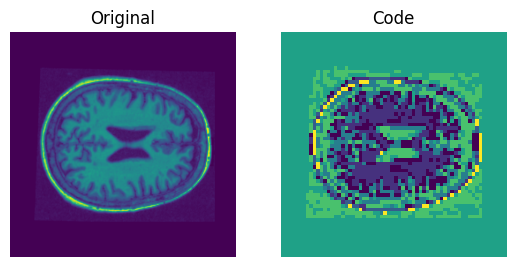

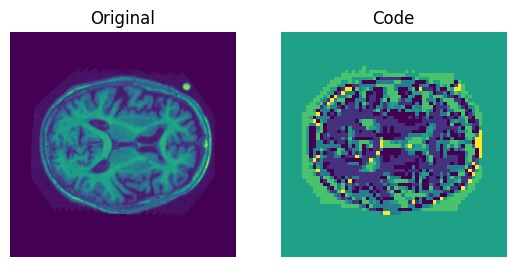

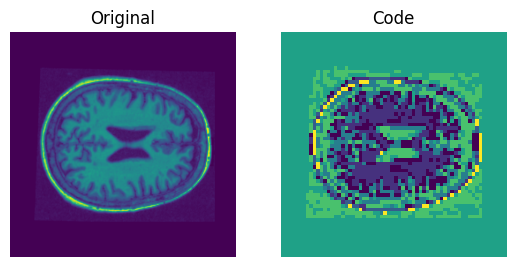

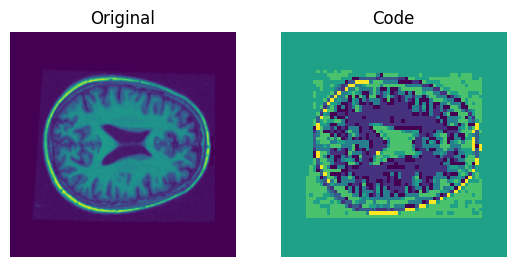

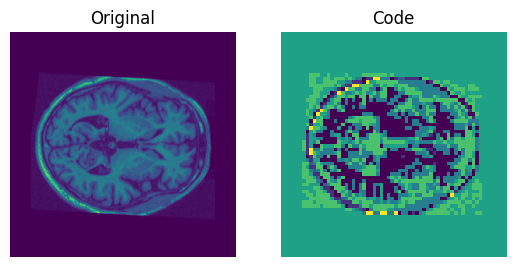

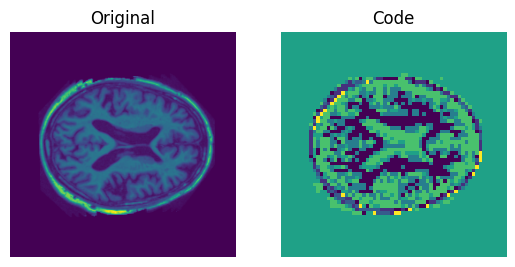

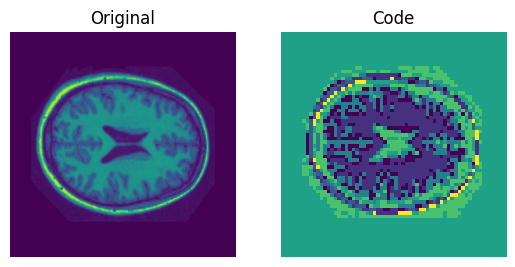

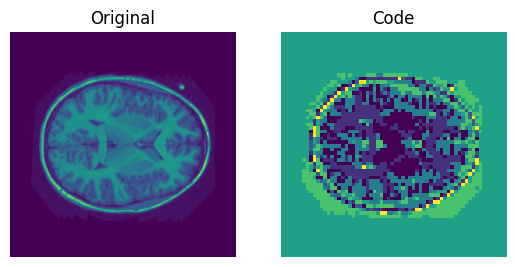

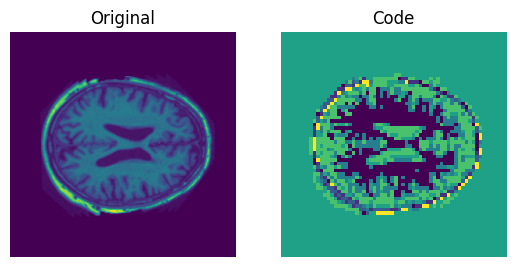

In [5]:
encoder_output_shape = reconstruct_oasis(vqvae_trainer, test_np)

Now that the Auto-Encoder has been trained and built, a CNN can be used to provide the generative aspect of the task. The process is:
- Pass images to the encoder
- Obtain the latent representation (encoding, using the VQ)
- Pass the encoded representation to the PixelCNN 
- Use the PixelCNN to generate a new encoded representation (training)
- Once trained, use the PixelCNN to generate encodings from random noise (?)




In [6]:
pixel_cnn = initialise_pixel(encoder_output_shape, vqvae_trainer)
pixel_cnn_model = pixel_cnn.model
codebook_indices = prepare_encodings(train_np, vqvae_trainer)
train_pixel(pixel_cnn_model, codebook_indices, 75, PIXEL_CHECKPOINT, LOAD_WEIGHTS=LOAD_WEIGHTS)


Input shape of the PixelCNN: (64, 64)
500/500 [==============================] - 1s 1ms/step
Epoch 1/75
113/113 [==============================] - 10s 72ms/step - loss: 1.0055 - accuracy: 0.6845 - val_loss: 1.3171 - val_accuracy: 0.6033
Epoch 2/75
113/113 [==============================] - 5s 43ms/step - loss: 0.6470 - accuracy: 0.7587 - val_loss: 1.0789 - val_accuracy: 0.6033
Epoch 3/75
113/113 [==============================] - 4s 35ms/step - loss: 0.5807 - accuracy: 0.7743 - val_loss: 0.8364 - val_accuracy: 0.6663
Epoch 4/75
113/113 [==============================] - 3s 28ms/step - loss: 0.5450 - accuracy: 0.7834 - val_loss: 0.6322 - val_accuracy: 0.7500
Epoch 5/75
113/113 [==============================] - 3s 28ms/step - loss: 0.5217 - accuracy: 0.7900 - val_loss: 0.5462 - val_accuracy: 0.7855
Epoch 6/75
113/113 [==============================] - 3s 29ms/step - loss: 0.5072 - accuracy: 0.7942 - val_loss: 0.4889 - val_accuracy: 0.8005
Epoch 7/75
113/113 [============================

1/1 [==============================] - 0s 38ms/step
Prior shape: (10, 64, 64)
1/1 [==============================] - 0s 81ms/step


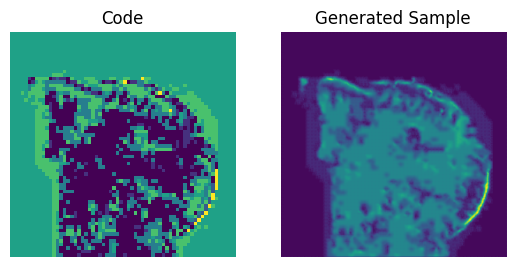

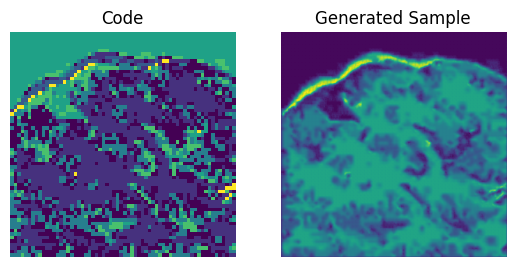

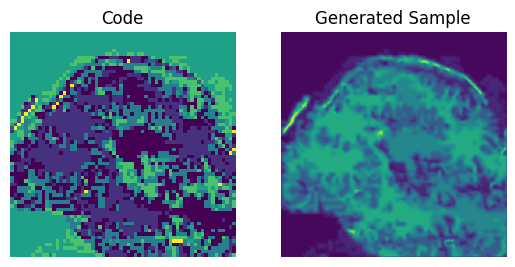

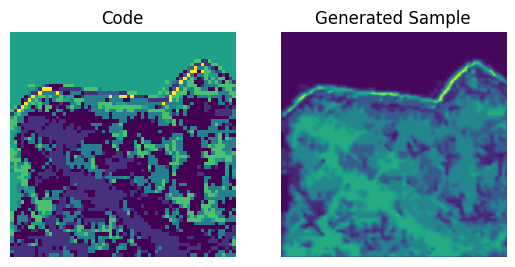

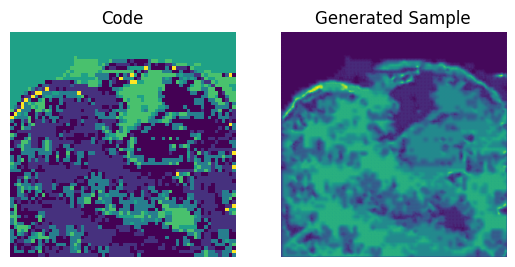

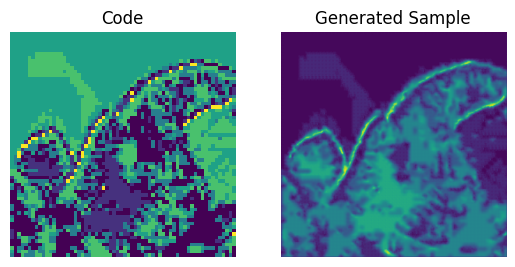

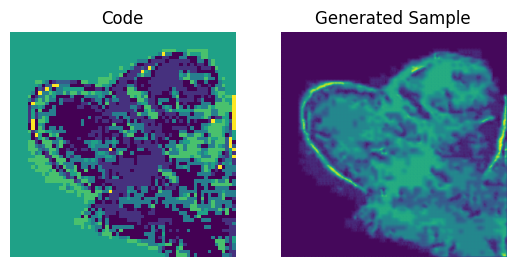

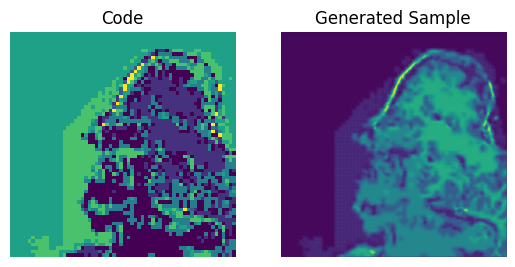

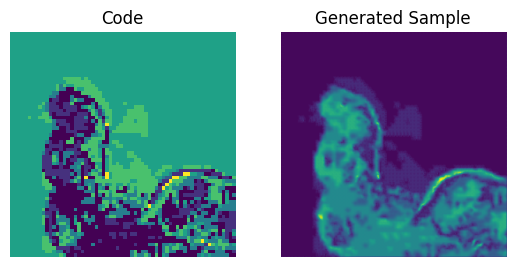

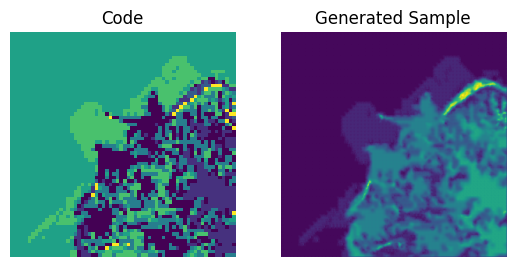

In [7]:
sampler_model = get_sampler(pixel_cnn_model)
priors = get_priors(pixel_cnn_model, sampler_model)
quantized_priors = quantize_priors(priors, vqvae_trainer, encoder_output_shape)
generator(vqvae_trainer, quantized_priors, priors)